# Motifs ordering exploration

## Maria Inês Silva
## 30/01/2019

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cwd = os.getcwd()
data_folder = os.path.abspath(os.path.join(cwd, os.pardir, 'data'))
output_folder = os.path.abspath(os.path.join(cwd, os.pardir, 'outputs/experiments_v4'))

In [3]:
def load_motif_data(folder):
    ts_1d = pickle.load(open(os.path.join(folder, "ts_1d.p"), "rb"))
    mdl_cost_list = pickle.load(open(os.path.join(folder, "mdl_cost.p"), "rb"))
    motif_point_list = pickle.load(open(os.path.join(folder, "motif_point.p"), "rb"))
    motif_center_list = pickle.load(open(os.path.join(folder, "motif_center.p"), "rb"))
    pattern_list = pickle.load(open(os.path.join(folder, "patterns.p"), "rb"))
    mean_dist = pickle.load(open(os.path.join(folder, "mean_dist.p"), "rb"))
    return ts_1d, mdl_cost_list, motif_point_list, motif_center_list, pattern_list, mean_dist


def load_ts_data(folder):
    trip_df = pd.read_pickle(os.path.join(folder, 'trip_df.pkl'))
    multi_dim_ts = trip_df[['ay', 'az']]
    events_ts = trip_df['event_type']
    return multi_dim_ts, events_ts


def plot_zoomin_motif(ts, motif_index, motif_point_list, events_ts,  x_lim):
    motif_pointers = motif_point_list[motif_index]
    event_df = pd.DataFrame([ts, events_ts.values]).T.reset_index()
    event_df.columns = ['index', 'var', 'event']
    fig = plt.figure(figsize=(25,10))
    plt.subplot(3,1,1)
    plt.plot(ts, 'tab:gray')
    for temp_point in motif_pointers:
        plt.plot(temp_point, ts[temp_point], 'tab:blue')
    sns.scatterplot(x="index", y="var", hue="event", data=event_df[event_df['event']>0], legend=False,
                    palette=sns.xkcd_palette(['red', 'tangerine', 'greenish yellow']))
    plt.ylim(min(ts), max(ts))
    plt.xlim(x_lim)
    return fig

## Data import

In [4]:
multi_dim_ts, events_ts = load_ts_data(data_folder)

folder = os.path.join(output_folder, 'trip_exp1')
ts_1d, mdl_cost_list, motif_point_list, motif_center_list, pattern_list, mean_dist = load_motif_data(folder)

## Computing the events partition for each motif

In [29]:
def compute_event_partition(motif_point_list, events_ts):
    motif_event_partition_list = []
    for motif_point in motif_point_list:
        motif_events_dic_list = []
        for member in motif_point:
            member_events_list = [events_ts[i] for i in member]
            member_events_dic = {'brakes': np.sum([member_event==1 for member_event in member_events_list]),
                                 'turns': np.sum([member_event==2 for member_event in member_events_list]),
                                 'accelerations': np.sum([member_event==3 for member_event in member_events_list])}
            motif_events_dic_list.append(member_events_dic)
        motif_events_partition = pd.DataFrame(motif_events_dic_list).sum()
        if np.mean(motif_events_partition)==0:
            motif_events_partition['dispersion'] = 0
        else:
            motif_events_partition['dispersion'] = round(np.std(motif_events_partition)/float(np.mean(motif_events_partition)), 2)
        motif_event_partition_list.append(motif_events_partition)
    motif_partition_df = pd.DataFrame(motif_event_partition_list)
    return motif_partition_df

In [31]:
motif_partition_df = compute_event_partition(motif_point_list, events_ts)
motif_partition_df.head()

,accelerations,brakes,turns,dispersion
0,3.0,1.0,2.0,0.41
1,2.0,3.0,0.0,0.75
2,3.0,1.0,5.0,0.54
3,1.0,2.0,2.0,0.28
4,11.0,7.0,15.0,0.30


In [ ]:
def get_motif_label(row):
    

motif_partition_df.head()

## Create motif table

In [32]:
def create_motif_table(pattern_list, motif_point_list, mdl_cost_list, mean_dist, events_ts):
    motif_dic = {'pattern' : pattern_list,
                 'pattern_len' : [len(pattern) for pattern in pattern_list],
                 'n_members' : [len(temp_motif) for temp_motif in motif_point_list],
                 'mdl_cost' : mdl_cost_list,
                 'mean_dist' : mean_dist}
    motif_partition_df = compute_event_partition(motif_point_list, events_ts)
    motif_df = pd.DataFrame(motif_dic) \
                        .join(motif_partition_df) \
                        .assign(mdl_cost = lambda x: x['mdl_cost'].round(1)) \
                        .sort_values('mdl_cost')
    return motif_df

In [33]:
motif_df = create_motif_table(pattern_list, motif_point_list, mdl_cost_list, mean_dist, events_ts)
motif_df.head()

,pattern,pattern_len,n_members,mdl_cost,mean_dist,accelerations,brakes,turns,dispersion
50,[bdc],1,240,47472.5,0.178033,8.0,10.0,4.0,0.34
26,[cbd],1,235,47771.4,0.117668,12.0,9.0,7.0,0.22
21,[bcd],1,212,48641.1,0.111195,8.0,8.0,6.0,0.13
16,[dbc],1,220,48724.4,0.097910,3.0,8.0,8.0,0.37
44,[cdb],1,215,49101.1,0.110176,6.0,7.0,6.0,0.07


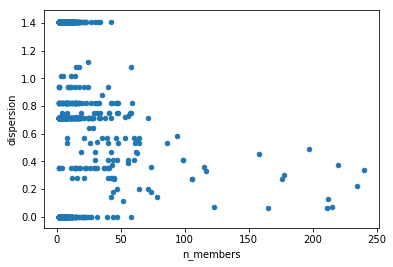

In [34]:
motif_df.plot.scatter('n_members', 'dispersion')
plt.show()

In [37]:
single_event_df = motif_df[motif_df['dispersion']>1.4]
len(single_event_df)

844

In [38]:
temp = single_event_df['accelerations']+single_event_df['turns']+single_event_df['brakes']
temp.describe()

count    844.000000
mean       1.114929
std        0.350989
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
dtype: float64

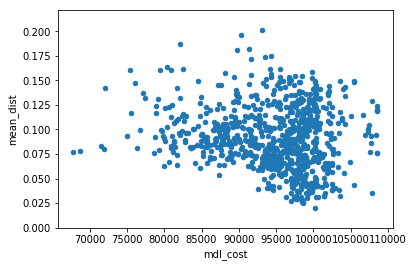

In [39]:
single_event_df.plot.scatter('mdl_cost', 'mean_dist')
plt.show()

In [40]:
max_brake = np.sum([event==1 for event in events_ts])
max_turn = np.sum([event==2 for event in events_ts])
max_acc = np.sum([event==3 for event in events_ts])
print(max_brake, max_turn, max_acc)

23 35 21


In [ ]:
motif_df.sort_values('accelerations', ascending=False).head(10)

In [ ]:
motif_df.sort_values('brakes', ascending=False).head(10)

In [42]:
single_event_df.sort_values('turns', ascending=False).head(10)

,pattern,pattern_len,n_members,mdl_cost,mean_dist,accelerations,brakes,turns,dispersion
701,"[cdb, ccc, dbd]",3,5,88425.8,0.098710,0.0,0.0,3.0,1.41
317,"[dda, eda]",2,27,72109.2,0.142471,0.0,0.0,3.0,1.41
928,"[dda, eda, eca]",3,23,75376.2,0.161172,0.0,0.0,3.0,1.41
332,"[ccc, dbd]",2,11,82735.4,0.088990,0.0,0.0,3.0,1.41
1574,"[dbc, cbd, bcd]",3,10,82382.7,0.098054,0.0,0.0,2.0,1.41
2520,"[cbe, bbe, ace, add]",4,9,84505.5,0.103928,0.0,0.0,2.0,1.41
649,"[ebb, dcb, dcc]",3,3,95203.2,0.111310,0.0,0.0,2.0,1.41
964,"[add, acd, bcd]",3,4,92878.5,0.106541,0.0,0.0,2.0,1.41
2972,"[cbd, cbe, bbe, ace, add, acd]",6,2,100795.9,0.130738,0.0,0.0,2.0,1.41
807,"[dbc, dcb, dda]",3,4,95899.2,0.149915,0.0,0.0,2.0,1.41


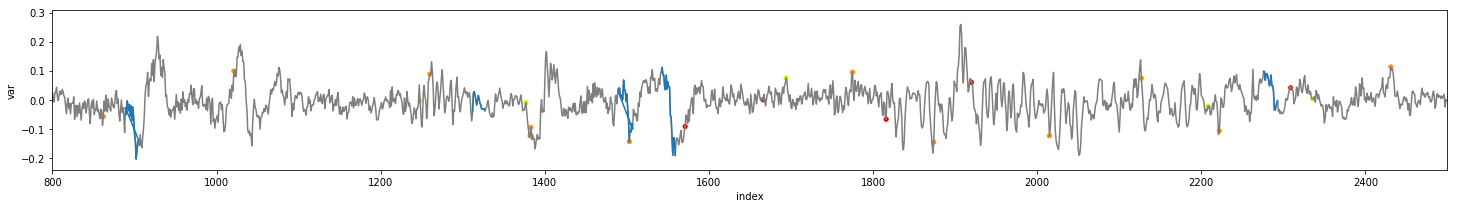

In [43]:
plot_zoomin_motif(ts_1d, 317, motif_point_list, events_ts,  [800, 2500])
plt.show()

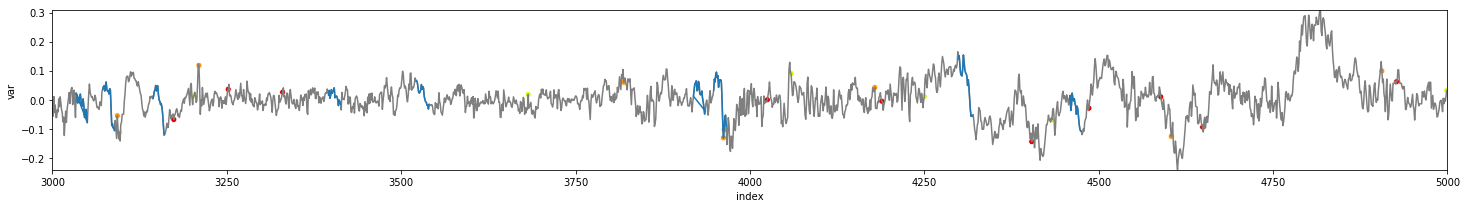

In [44]:
plot_zoomin_motif(ts_1d, 317, motif_point_list, events_ts,  [3000, 5000])
plt.show()

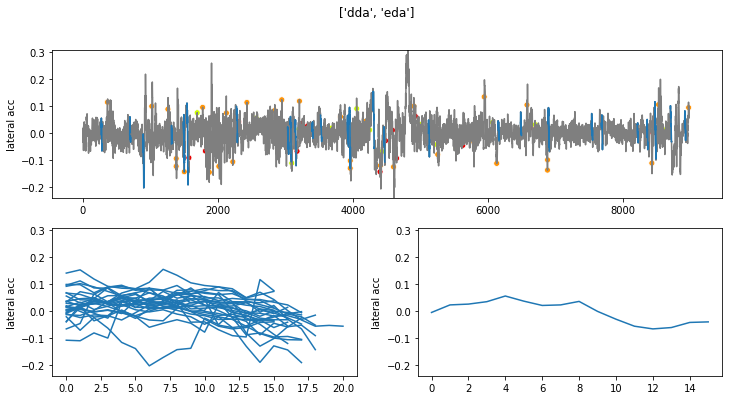

In [46]:
# extendedMD code
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
from extendedMD.motif_viz import plot_single_motif

plot_single_motif(ts_1d, events_ts, 317, motif_point_list, motif_center_list, pattern_list, 'lateral acc')
plt.show()

In [ ]:
plot_single_motif(ts_1d, events_ts, 37, motif_point_list, motif_center_list, pattern_list, 'pca')
plt.show()